## Comparison penalized and unpenalized curves (Fig 2.2)

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
from scipy.special import erf 

In [90]:
def f_def(x: np.ndarray) -> np.ndarray:
    return 5 + erf(15 * x - 3) + erf(30 * x - 12) + erf(45 * x - 27) + erf(60 * x - 48)

# Simulate the data 
np.random.seed(0)
n =  100
x = np.random.uniform(0, 1, n)
f = f_def(x)-np.mean(f_def(x))

# Generate thinner covariate sample so the plot looks smoother (not used to fit
# the data, only to predict new values with the fitted coefficients)
x_ext = np.linspace(np.min(x),np.max(x),100)
f_ext = f_def(x_ext)-np.mean(f_def(x_ext))

y= f + np.random.normal(0, 0.2, 100)
y_ext = f_ext

In [91]:
#Create the B-spline matrix
def my_bbase(x, xl, xr, ndx=10, bdeg=3, eps=1e-05):
    dx = (xr - xl) / ndx
    knots = np.arange(xl - bdeg * dx, xr + bdeg * dx, dx)
    c = np.eye(len(knots) - bdeg )
    B = BSpline(knots, c, bdeg)(x)
    
    return B
B = my_bbase(x, np.min(x), np.max(x), 40, 3) 
B = B.squeeze()
B_ext = my_bbase(x_ext, np.min(x_ext), np.max(x_ext), 40, 3)
B_ext =B_ext.squeeze()

### PENALIZED OPTIMIZATION PROBLEM

In [ ]:
import gurobipy as gp
from gurobipy import GRB

# Problem data
k =  40
lambda_val =  0.1

# Create the model
model = gp.Model("UnconstrainedOptimization")

# Create variables
theta = {}
for j in range(k+3):
    theta[j] = model.addVar(lb=-GRB.INFINITY, name=f"theta_{j}")

# Objective function
obj = (gp.quicksum((y[i] - gp.quicksum(theta[j] * B[i][j] for j in range(k+3)))**2 for i in range(n))
       + lambda_val * gp.quicksum((theta[j] - 2 * theta[j-1] + theta[j-2])**2 for j in range(3, k+3)))
model.setObjective(obj, GRB.MINIMIZE)

# Optimize the model
model.optimize()

In [93]:
# Calculate the predicted y values using the optimized theta values and B matrix
opt_theta=[theta[j].X for j in range(k+3)]
y_pred = np.dot(B_ext, opt_theta)

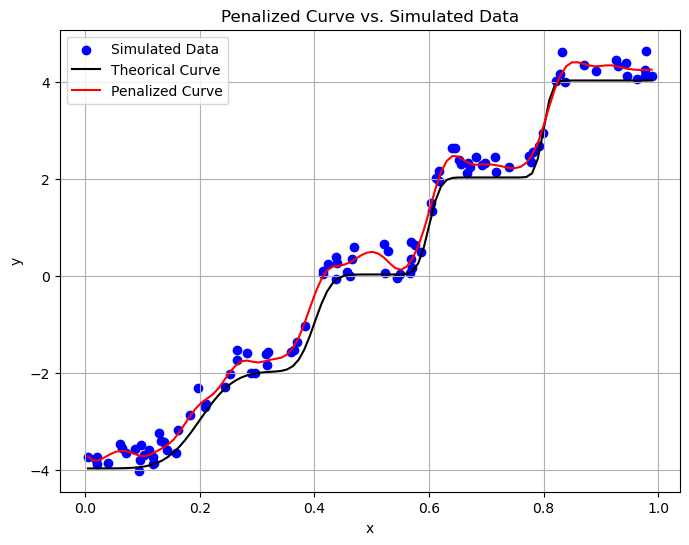

In [94]:
# Plot of the simulated data vs penalized curve
plt.figure(figsize=(8, 6))
plt.scatter(x2, y, color='blue', label='Simulated Data')
plt.plot(x2_ext, y_ext, color='black', label='Theorical Curve')
plt.plot(x2_ext, y_pred, color='red', label='Penalized Curve')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Penalized Curve vs. Simulated Data')
plt.legend()
plt.grid(True)
plt.show()

### NO PENALIZED OPTIMIZATION PROBLEM

In [ ]:
import gurobipy as gp
from gurobipy import GRB

# Problem data
n =  100
k =  40
lambda_val =  0.1

# Create the model
model = gp.Model("UnconstrainedOptimization")

# Create variables
theta = {}
for j in range(k+3):
    theta[j] = model.addVar(lb=-GRB.INFINITY, name=f"theta_{j}")

# Objective function without penalization
obj = (gp.quicksum((y[i] - gp.quicksum(theta[j] * B[i][j] for j in range(k+3)))**2 for i in range(n)))
model.setObjective(obj, GRB.MINIMIZE)

# Optimize the model
model.optimize()

In [96]:
# Calculate the predicted y values using the optimized theta values and B matrix
opt_theta=[theta[j].X for j in range(k+3)]
y_pred = np.dot(B_ext, opt_theta)

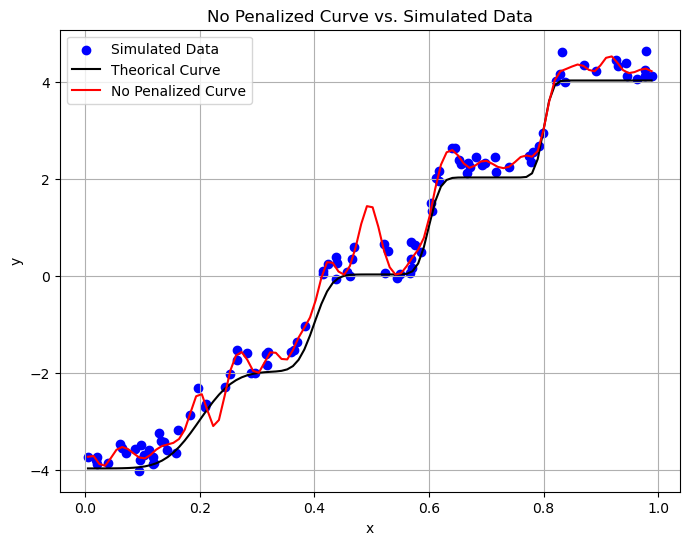

In [100]:
# Plot of the simulated data vs unpenalized curve
plt.figure(figsize=(8, 6))
plt.scatter(x2, y, color='blue', label='Simulated Data')
plt.plot(x2_ext, y_ext, color='black', label='Theorical Curve')
plt.plot(x2_ext, y_pred, color='red', label='No Penalized Curve')
plt.xlabel('x')
plt.ylabel('y')
plt.title('No Penalized Curve vs. Simulated Data')
plt.legend()
plt.grid(True)
plt.show()